In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorenz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.3 MB/s eta 0:00:00


Data shape: (1048575,)


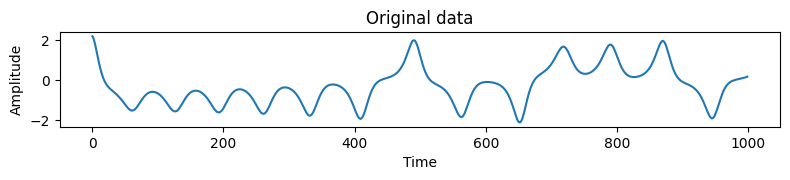

In [3]:
# @title Daat reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv

nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

# standardization
mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

#######
#Visualiation

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Input gate $i_t$,

Forget gate $f_t$,

$h$: Sigmoid and omit the biases:


\begin{equation*}
\begin{split}
i_t &= h(W_{\mathrm{datain}} d_t + W_{\mathrm{gatein}} c_{t-1}),\\
f_t &= h(W_{\mathrm{dataforget}} d_t + W_{\mathrm{forget}} c_{t-1}),\\
\tilde{c}_t &= \tanh\!\left(W_{\mathrm{dataout}} d_t + W_{\mathrm{gateout}} (f_t \odot c_{t-1})\right),\\
c_t &= (1 - i_t)\odot c_{t-1} + i_t \odot \tilde{c}_t,\\
x_t &= c_t
\end{split}
\end{equation*}




 The operator $\odot$ denotes the Hadamard product (element-wise product).

 ($W_{\mathrm{dataout}}$ and $W_{\mathrm{gateout}}$ must be corresponding to the candidate hidden state matrices.)

In [4]:
# @title Definition of GRU

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

 # Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low



# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def make_connection(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

####################
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def Reservoir(x_in,x,W):
        x =  np.tanh(np.dot(W, x) + x_in)
        return x

def Gate(x_in,x,W):
        x =  sigmoid(np.dot(W, x) + x_in)
        return x

#####################

def GRU(x,c,x_gatein,Wgatein,x_cell,Wcell,x_forget,Wforget,x_gateout,Wgateout):

        c_new = Reservoir(x_gateout,c * Gate(x_forget,c,Wforget),Wgateout)
        c = (1-Gate(x_gatein,c,Wgatein)) * c +Gate(x_gatein,c,Wgatein) *c_new

        #x = Gate(x_gateout,c,Wgateout) * np.tanh(c) #Peephole

        return x,c

####################
#Ridge Regression and  Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x,c, T_train,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len):

    x = np.zeros(N_x)
    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):


            # reservoir state vector
        x,c = GRU(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

            # teacher data
        d = train_D[n,:]

        if n > discard_len:   # discard the first part of the data
            ##X_XT, D_XT = Ridge(d, x, X_XT, D_XT)
            X_XT, D_XT = Ridge(d, c, X_XT, D_XT)

    return X_XT, D_XT,x,c

########################
#induction formula for creating estimated data
########################

def run(test_U,x,c,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test):


    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x,c = GRU(x,c,np.dot(Wdatain,y),Wgatein, np.dot(Wdatacell,y), \
                   Wcell,np.dot(Wdataforget,y),Wforget,np.dot(Wdataout,y),Wgateout)

        ##y_pred = np.dot(Wout, x)
        y_pred = np.dot(Wout, c)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [5]:
# @title Definition of Bayesian optimization of GRU

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))

################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 28)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density_gate = trial.suggest_float("density_gate", 0.01, 1)
    density_res = trial.suggest_float("density_res", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho_gate = trial.suggest_float("rho_gate", 0, 1.5)
    rho_res = trial.suggest_float("rho_res", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value_datain = trial.suggest_float("seed_value_datain", 0, 100)
    seed_value_gatein = trial.suggest_float("seed_value_gatein", 0, 100)
    seed_value_datacell = trial.suggest_float("seed_value_datacell", 0, 100)
    seed_value_cell = trial.suggest_float("seed_value_cell", 0, 100)
    seed_value_dataforget = trial.suggest_float("seed_value_dataforget", 0, 100)
    seed_value_forget = trial.suggest_float("seed_value_forget", 0, 100)
    seed_value_dataout = trial.suggest_float("seed_value_dataout", 0, 100)
    seed_value_gateout = trial.suggest_float("seed_value_gateout", 0, 100)

###############

    T_0 = T_train + lag * dim
###############
#Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

###############
#Convert data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)


    for i in range(dim):

        data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]


# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)
    c_special = np.zeros(N_x)

    X_XT, D_XT,x_special,c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

 # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

##############################
#Calculate RMSE (we compare with TensorFlow)
##############################

    pred_D = np.zeros((T_train,dim), dtype=float)
    x = np.zeros(N_x)
    c = np.zeros(N_x)

    for n in range(T_train):

        x,c = GRU(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

        ##pred_D[n,:] = np.dot(Wout, x)
        pred_D[n,:] = np.dot(Wout, c)

    return np.sqrt(np.mean((pred_D[discard_len:]-train_D[discard_len:])**2))

1048575
CPU times: user 80 µs, sys: 0 ns, total: 80 µs
Wall time: 85.1 µs


In [6]:
# @title Implementation of Bayesian optimization of GRU

%%time

n_trials    = 30   # Number of times to test with optuna (generate RMSE for this number of times)
T_train     = 5000 # Training period
T_test      = 100  # Forecast period
Node        = 80   # Node

discard_len   = 10 # Number of steps not learned at the beginning (not important)
MAX_TRIALS  = 8    # Repeat the same thing while shifting each one step to produce robust result


test_num    = 3000 # Number of times for one test (to get one generalization error in MAE)
synchro_len = 70   #Steps to generate initial hidden layer vector

###################################

mean_score  = []
score       = []

###################################
#Convert data to Implement set for each trial

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")


    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials)

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density_gate = trial.params["density_gate"]
    density_res = trial.params["density_res"]
    input_scale = trial.params["input_scale"]
    rho_gate    = trial.params["rho_gate"]
    rho_res     = trial.params["rho_res"]
    alpha       = trial.params["alpha"]
    seed_value_datain      = trial.params["seed_value_datain"]
    seed_value_gatein      = trial.params["seed_value_gatein"]
    seed_value_datacell    = trial.params["seed_value_datacell"]
    seed_value_cell        = trial.params["seed_value_cell"]
    seed_value_dataforget  = trial.params["seed_value_dataforget"]
    seed_value_forget      = trial.params["seed_value_forget"]
    seed_value_dataout     = trial.params["seed_value_dataout"]
    seed_value_gateout     = trial.params["seed_value_gateout"]

###################################
##Training phase
###################################
    #Test start time

    T_0 = T_train+lag*dim

    #Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

    #Convert training data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

          data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

    #Ridge
    X_XT, D_XT,x_special, c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

    #Generate output weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###################################
##Test phase
###################################

    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

    #Convert test data to a delay coordinate system

    for t in range(test_num):

          for i in range(dim):

              data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                            :T_0+t+T_test-i*lag+1]
    # Initialization of test data

    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))


    ##The last time data of the training data output must overlap with the test data!

    x_conti = None
    for t in range(test_num):


        X_XT, D_XT,x_conti,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                    data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),np.zeros(N_x),synchro_len,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,0)


        #Predictive data generation

        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_conti,c_conti,Wdatain,Wgatein,Wdatacell, \
                                      Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test)

        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1
                                :T_train+T_test+1,0,t]


    mae = MAE( test_Y[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('Average of MAE:',np.mean(score))


[I 2025-08-25 04:00:31,887] A new study created in memory with name: no-name-fa8936f1-4086-4473-8937-433df01672be


Trial 1/8


[I 2025-08-25 04:00:32,525] Trial 0 finished with value: 0.012356327271299695 and parameters: {'lag': 5, 'dim': 10, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7779624433461046, 'density_res': 0.9098170238837956, 'input_scale': 1.469840042693273, 'rho_gate': 0.32383794591598586, 'rho_res': 1.3892653545796496, 'alpha': 0.3186838249960321, 'seed_value_datain': 19.493288723513523, 'seed_value_gatein': 25.77071344821106, 'seed_value_datacell': 5.8039064321921625, 'seed_value_cell': 71.99489471971297, 'seed_value_dataforget': 46.459438656736666, 'seed_value_forget': 0.4503300711793057, 'seed_value_dataout': 66.9542306719751, 'seed_value_gateout': 59.87713451410922}. Best is trial 0 with value: 0.012356327271299695.
[I 2025-08-25 04:00:33,105] Trial 1 finished with value: 0.0019257397178317507 and parameters: {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.36423889731780934, 'density_res': 0.04198119659949077, 'input_scale': 0.975643173035574, 'rho_gate': 0.079843819785045

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.36423889731780934, 'density_res': 0.04198119659949077, 'input_scale': 0.975643173035574, 'rho_gate': 0.07984381978504507, 'rho_res': 0.5191037058708453, 'alpha': 0.9481036692046565, 'seed_value_datain': 17.517240640504973, 'seed_value_gatein': 25.461915282946958, 'seed_value_datacell': 65.86974578075416, 'seed_value_cell': 77.16133134679646, 'seed_value_dataforget': 51.43130464672705, 'seed_value_forget': 7.9102294513375355, 'seed_value_dataout': 5.715753184185068, 'seed_value_gateout': 38.6731765436265},
  'value': 0.0019257397178317507,


[I 2025-08-25 04:01:18,580] A new study created in memory with name: no-name-2a88065d-ac55-470d-b9cf-e43a86ea1b21


MAE: 0.11119905453118721
Average of MAE: 0.11119905453118721
Trial 2/8


[I 2025-08-25 04:01:19,048] Trial 0 finished with value: 0.027680462588678494 and parameters: {'lag': 9, 'dim': 26, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.30093179657867714, 'density_res': 0.3114424639755098, 'input_scale': 0.17424645916940357, 'rho_gate': 1.1594170003537179, 'rho_res': 0.5853887844528068, 'alpha': 0.33224343261594647, 'seed_value_datain': 45.74033128730787, 'seed_value_gatein': 16.202773174616524, 'seed_value_datacell': 52.81051780576208, 'seed_value_cell': 15.787085334418926, 'seed_value_dataforget': 17.639409769907733, 'seed_value_forget': 96.21037934455127, 'seed_value_dataout': 64.17540906883924, 'seed_value_gateout': 35.675530953041765}. Best is trial 0 with value: 0.027680462588678494.
[I 2025-08-25 04:01:19,512] Trial 1 finished with value: 0.04985553544161574 and parameters: {'lag': 10, 'dim': 19, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.04824367725486776, 'density_res': 0.03367946456412538, 'input_scale': 0.597115303560692, 'rho_gate': 0.28017345264

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.18943171319814542, 'density_res': 0.59613776993346, 'input_scale': 0.5865637238696738, 'rho_gate': 0.8964791310544926, 'rho_res': 0.23112261700652598, 'alpha': 0.4817050944681677, 'seed_value_datain': 64.5128403611375, 'seed_value_gatein': 29.302215782637916, 'seed_value_datacell': 78.54096842679188, 'seed_value_cell': 71.87191238867423, 'seed_value_dataforget': 88.23909601612807, 'seed_value_forget': 55.67827006235489, 'seed_value_dataout': 68.4550902843196, 'seed_value_gateout': 42.14467300404701},
  'value': 0.0018465904811873685,


[I 2025-08-25 04:01:56,846] A new study created in memory with name: no-name-f71b0007-1fc0-489a-8831-44cfaf145dcf


MAE: 0.0956601102634101
Average of MAE: 0.10342958239729866
Trial 3/8


[I 2025-08-25 04:01:57,288] Trial 0 finished with value: 0.0026757495240882145 and parameters: {'lag': 4, 'dim': 10, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4226387026360102, 'density_res': 0.7370510270201958, 'input_scale': 0.9365934052863933, 'rho_gate': 0.21418235205216746, 'rho_res': 0.34247711007248166, 'alpha': 0.7746464118861688, 'seed_value_datain': 15.649944104329737, 'seed_value_gatein': 72.24710987475126, 'seed_value_datacell': 17.69733372378125, 'seed_value_cell': 24.151633670925442, 'seed_value_dataforget': 9.054279864102577, 'seed_value_forget': 71.5627158320943, 'seed_value_dataout': 95.39337789280754, 'seed_value_gateout': 84.30372342195305}. Best is trial 0 with value: 0.0026757495240882145.
[I 2025-08-25 04:01:57,735] Trial 1 finished with value: 0.00359829469315181 and parameters: {'lag': 6, 'dim': 8, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.6393390634746979, 'density_res': 0.7526238643594167, 'input_scale': 0.9478238984470806, 'rho_gate': 1.267123194334465,

Best trial:
  'params': {'lag': 3, 'dim': 11, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8249918225115074, 'density_res': 0.9537934239239154, 'input_scale': 0.541137148785866, 'rho_gate': 0.3559217418579911, 'rho_res': 1.1476062230883022, 'alpha': 0.10386882231592834, 'seed_value_datain': 64.18261374799266, 'seed_value_gatein': 84.0023934716214, 'seed_value_datacell': 25.95906001125467, 'seed_value_cell': 42.04405364189636, 'seed_value_dataforget': 91.8115277721503, 'seed_value_forget': 99.45902338818956, 'seed_value_dataout': 72.580574708486, 'seed_value_gateout': 86.13773530102532},
  'value': 0.0019556108234380877,


[I 2025-08-25 04:02:35,731] A new study created in memory with name: no-name-d364882f-21f9-48f2-a673-a71e64517ae0


MAE: 0.11597543624793347
Average of MAE: 0.1076115336808436
Trial 4/8


[I 2025-08-25 04:02:36,178] Trial 0 finished with value: 0.0025090500424799697 and parameters: {'lag': 8, 'dim': 3, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4681448512077213, 'density_res': 0.49411320268322045, 'input_scale': 0.12218211707761778, 'rho_gate': 0.23841077852056564, 'rho_res': 0.36676554403056144, 'alpha': 0.8187327172500914, 'seed_value_datain': 37.686634041082044, 'seed_value_gatein': 71.5849129110435, 'seed_value_datacell': 12.086851639700058, 'seed_value_cell': 95.24441504159937, 'seed_value_dataforget': 35.44158492933305, 'seed_value_forget': 24.637944331543103, 'seed_value_dataout': 18.245041916706207, 'seed_value_gateout': 84.71439982430063}. Best is trial 0 with value: 0.0025090500424799697.
[I 2025-08-25 04:02:36,637] Trial 1 finished with value: 0.006461656268938301 and parameters: {'lag': 10, 'dim': 11, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.6104892126574489, 'density_res': 0.5339567161599801, 'input_scale': 0.2923933817988508, 'rho_gate': 1.4679219346

Best trial:
  'params': {'lag': 3, 'dim': 9, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.9588609641864061, 'density_res': 0.6548155636198937, 'input_scale': 0.47164074043098003, 'rho_gate': 0.2181152797706069, 'rho_res': 0.9362103386195151, 'alpha': 0.11449208504875347, 'seed_value_datain': 15.460393057947556, 'seed_value_gatein': 26.941548810627857, 'seed_value_datacell': 39.64547995617151, 'seed_value_cell': 37.35048304584982, 'seed_value_dataforget': 70.46226308541536, 'seed_value_forget': 22.943858799146817, 'seed_value_dataout': 73.47025216525361, 'seed_value_gateout': 68.22621057630337},
  'value': 0.0018925842712488174,


[I 2025-08-25 04:03:13,710] A new study created in memory with name: no-name-d77d9afa-4754-41d6-8fc3-b69eda31dbeb


MAE: 0.10821513476630908
Average of MAE: 0.10776243395220997
Trial 5/8


[I 2025-08-25 04:03:14,196] Trial 0 finished with value: 0.012042837210882841 and parameters: {'lag': 4, 'dim': 24, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.10276530273833345, 'density_res': 0.2651765418248917, 'input_scale': 0.5388067174136729, 'rho_gate': 0.3832688644490428, 'rho_res': 0.7765435181105365, 'alpha': 0.48187571292386255, 'seed_value_datain': 78.29832010092905, 'seed_value_gatein': 25.19351112508278, 'seed_value_datacell': 39.28244698480745, 'seed_value_cell': 20.50075578670296, 'seed_value_dataforget': 59.03295470181122, 'seed_value_forget': 25.28880393868722, 'seed_value_dataout': 73.44604928080884, 'seed_value_gateout': 22.313472000487856}. Best is trial 0 with value: 0.012042837210882841.
[I 2025-08-25 04:03:14,650] Trial 1 finished with value: 0.044281686899125254 and parameters: {'lag': 4, 'dim': 23, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.142481712676111, 'density_res': 0.2553674717240051, 'input_scale': 1.286051395992516, 'rho_gate': 1.44246133605724, 'r

Best trial:
  'params': {'lag': 3, 'dim': 8, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.3857375202095838, 'density_res': 0.5901325339281878, 'input_scale': 0.4159538157324823, 'rho_gate': 1.3245125995064255, 'rho_res': 1.4903518913707647, 'alpha': 0.9002379513454807, 'seed_value_datain': 24.720540109300092, 'seed_value_gatein': 55.93116506049702, 'seed_value_datacell': 11.501019015605163, 'seed_value_cell': 38.49002283784077, 'seed_value_dataforget': 0.3959461352360234, 'seed_value_forget': 36.47278469610358, 'seed_value_dataout': 85.29502732397144, 'seed_value_gateout': 57.73789512230202},
  'value': 0.0018289656480162105,


[I 2025-08-25 04:03:50,975] A new study created in memory with name: no-name-958c85c2-c68c-44d7-9317-bcf393f33dbb


MAE: 0.09644575129244125
Average of MAE: 0.10549909742025623
Trial 6/8


[I 2025-08-25 04:03:51,404] Trial 0 finished with value: 0.0019576137801656335 and parameters: {'lag': 3, 'dim': 4, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8760851327455068, 'density_res': 0.40591309548351645, 'input_scale': 0.24927902954685455, 'rho_gate': 0.8112073679941953, 'rho_res': 0.935929061665614, 'alpha': 0.433826318799469, 'seed_value_datain': 70.84225702961375, 'seed_value_gatein': 72.35089831617762, 'seed_value_datacell': 19.306540331198086, 'seed_value_cell': 14.813384781603634, 'seed_value_dataforget': 29.074397574393373, 'seed_value_forget': 82.7023112546067, 'seed_value_dataout': 82.2312138219623, 'seed_value_gateout': 60.69865552592441}. Best is trial 0 with value: 0.0019576137801656335.
[I 2025-08-25 04:03:51,844] Trial 1 finished with value: 0.0024654681468857693 and parameters: {'lag': 6, 'dim': 5, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.03736429726270805, 'density_res': 0.7486376017751456, 'input_scale': 1.1671839502167725, 'rho_gate': 0.9783794737005889

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.9349086048666919, 'density_res': 0.4866300654520131, 'input_scale': 0.5837127546922402, 'rho_gate': 0.5267226463720819, 'rho_res': 0.5013944891884847, 'alpha': 0.6058266328989008, 'seed_value_datain': 99.50010884217106, 'seed_value_gatein': 44.908308300585404, 'seed_value_datacell': 31.529854251477712, 'seed_value_cell': 10.32988248351974, 'seed_value_dataforget': 62.081851175123596, 'seed_value_forget': 73.28764995091812, 'seed_value_dataout': 99.46644587854585, 'seed_value_gateout': 91.52888087118984},
  'value': 0.001842273585508559,


[I 2025-08-25 04:04:27,792] A new study created in memory with name: no-name-36e9c6d7-1591-45ee-901e-733d5e85fff8


MAE: 0.07552353089551257
Average of MAE: 0.10050316966613228
Trial 7/8


[I 2025-08-25 04:04:28,268] Trial 0 finished with value: 0.05812713334718485 and parameters: {'lag': 9, 'dim': 22, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.674089891772233, 'density_res': 0.6582911869637303, 'input_scale': 0.4887739109215745, 'rho_gate': 0.9744110309460402, 'rho_res': 1.401703138962639, 'alpha': 0.9193179743972798, 'seed_value_datain': 23.939560867714683, 'seed_value_gatein': 81.62190998813202, 'seed_value_datacell': 76.51569337417145, 'seed_value_cell': 81.668699518491, 'seed_value_dataforget': 15.628256164878662, 'seed_value_forget': 68.79872995013812, 'seed_value_dataout': 53.068955008585526, 'seed_value_gateout': 12.669648369088405}. Best is trial 0 with value: 0.05812713334718485.
[I 2025-08-25 04:04:28,705] Trial 1 finished with value: 0.002502938586276893 and parameters: {'lag': 5, 'dim': 5, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7679477798289301, 'density_res': 0.7489439594598777, 'input_scale': 1.2767155450161893, 'rho_gate': 0.19542398955737023, 'rh

Best trial:
  'params': {'lag': 3, 'dim': 10, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.86830632817679, 'density_res': 0.2919122461089904, 'input_scale': 0.1977240287102925, 'rho_gate': 1.2426594487221108, 'rho_res': 0.6596860907115317, 'alpha': 0.684849761164423, 'seed_value_datain': 82.30175849731746, 'seed_value_gatein': 62.08906299178619, 'seed_value_datacell': 26.531511727128027, 'seed_value_cell': 14.955106549693117, 'seed_value_dataforget': 2.6646993312989764, 'seed_value_forget': 18.61194988865406, 'seed_value_dataout': 68.05349730288665, 'seed_value_gateout': 19.30084703803648},
  'value': 0.0018179394810814646,


[I 2025-08-25 04:05:05,855] A new study created in memory with name: no-name-ba36dc54-532f-4f85-8d92-445b036b8234


MAE: 0.1324432662871156
Average of MAE: 0.10506604061198706
Trial 8/8


[I 2025-08-25 04:05:06,483] Trial 0 finished with value: 0.0019581557708685986 and parameters: {'lag': 4, 'dim': 5, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7189151455100633, 'density_res': 0.2653345654397954, 'input_scale': 0.3819389253644133, 'rho_gate': 0.6609660987900128, 'rho_res': 1.4534519096824527, 'alpha': 0.8654784318763129, 'seed_value_datain': 10.096388056599404, 'seed_value_gatein': 83.13652590566397, 'seed_value_datacell': 30.080381031302938, 'seed_value_cell': 13.271205751764835, 'seed_value_dataforget': 78.00273773649957, 'seed_value_forget': 19.819888114666263, 'seed_value_dataout': 90.2300889492531, 'seed_value_gateout': 58.25741326046546}. Best is trial 0 with value: 0.0019581557708685986.
[I 2025-08-25 04:05:07,407] Trial 1 finished with value: 0.03444805636280535 and parameters: {'lag': 10, 'dim': 15, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8206817889867852, 'density_res': 0.3664070584359873, 'input_scale': 0.6023544634789421, 'rho_gate': 1.285124616848571

Best trial:
  'params': {'lag': 3, 'dim': 10, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4946699187480179, 'density_res': 0.03924229168953319, 'input_scale': 0.23218335790415595, 'rho_gate': 0.9868359232699824, 'rho_res': 0.7435969172330734, 'alpha': 0.01967681914859129, 'seed_value_datain': 0.7707731852530415, 'seed_value_gatein': 0.0027564068578771472, 'seed_value_datacell': 38.85091584859471, 'seed_value_cell': 26.485584449759738, 'seed_value_dataforget': 36.313289832594215, 'seed_value_forget': 14.423167698570214, 'seed_value_dataout': 67.4943270718471, 'seed_value_gateout': 79.60932194171403},
  'value': 0.0018471099612196382,
MAE: 0.23731539162490012
Average of MAE: 0.12159720948860117
CPU times: user 5min 26s, sys: 3.94 s, total: 5min 30s
Wall time: 5min 12s


Average of MAE: 0.12159720948860117


/tmp/ipython-input-2762027289.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


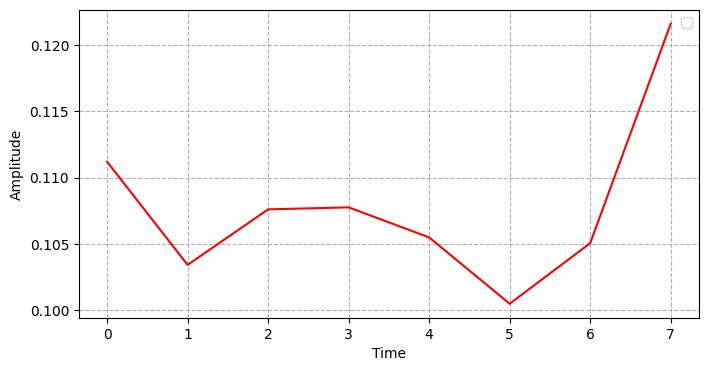

In [7]:
# @title Result of GRU prediction

mean_score = np.array(mean_score)

import matplotlib.pyplot as plt

print('Average of MAE:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.23731539162490012
forecast period: 100


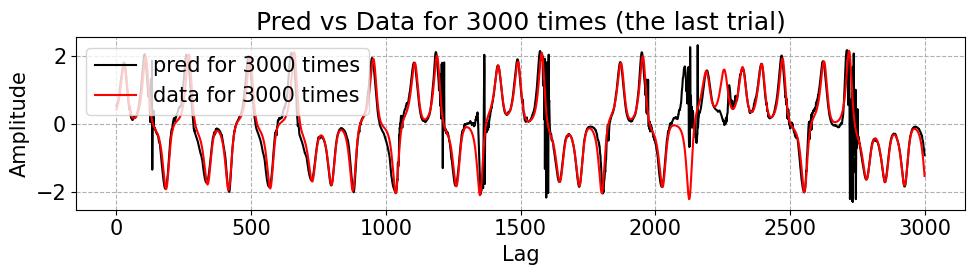

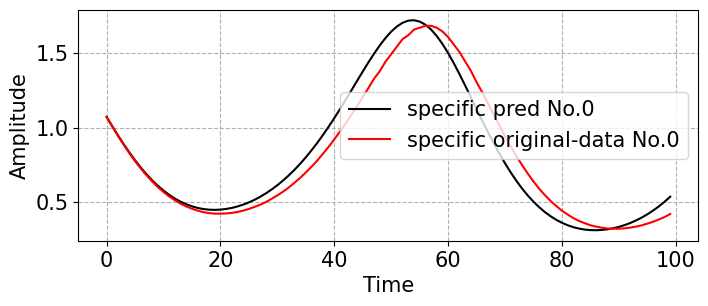

In [8]:
# @title Visualization (only the last trial)

print("MAE(the last trial):", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()